In [34]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Read CSV file
import pandas as pd

# Plotting library
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed to plot 3-D surfaces

# Feature engineering
import math

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# tells matplotlib to embed plots within the notebook
%matplotlib inline

In [35]:
# import training CSV
fname = './data/train.csv'
# use pandas to read the CSV properly of all different types
data_pd = pd.read_csv(fname)
# convert to a numpy array
data = np.array(data_pd)
# remove categorical data - force cast attempt then remove failures
cols_to_remove = []
for i in range(data.shape[1]):
    try:
        data[:,i] = data[:,i].astype(float)
    except:
        cols_to_remove.append(i)

data = np.delete(data, cols_to_remove, axis=1)
# remove rows with nan values
rows_to_remove = []
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if math.isnan(data[i,j]):
            rows_to_remove.append(i)
            break

data = np.delete(data, rows_to_remove, axis=0)

# remove outliers with standard deviation TODO()

# take the actual prices and add them to results y
y = data[:, data.shape[1] - 1]
# remove prices column from data
data = np.delete(data, data.shape[1] - 1, 1)
data = data.astype(float)
print("data shape", data.shape)
print("Y shape:", y.shape)

data_pd = pd.DataFrame(data)

data shape (1121, 37)
Y shape: (1121,)


In [36]:
data_pd.info()
data_pd.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1121 entries, 0 to 1120
Data columns (total 37 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1121 non-null   float64
 1   1       1121 non-null   float64
 2   2       1121 non-null   float64
 3   3       1121 non-null   float64
 4   4       1121 non-null   float64
 5   5       1121 non-null   float64
 6   6       1121 non-null   float64
 7   7       1121 non-null   float64
 8   8       1121 non-null   float64
 9   9       1121 non-null   float64
 10  10      1121 non-null   float64
 11  11      1121 non-null   float64
 12  12      1121 non-null   float64
 13  13      1121 non-null   float64
 14  14      1121 non-null   float64
 15  15      1121 non-null   float64
 16  16      1121 non-null   float64
 17  17      1121 non-null   float64
 18  18      1121 non-null   float64
 19  19      1121 non-null   float64
 20  20      1121 non-null   float64
 21  21      1121 non-null   float64
 22  

,count,mean,std,min,25%,50%,75%,max
0,1121.0,726.842105,420.769012,1.0,364.0,725.0,1091.0,1460.0
1,1121.0,56.146298,41.772684,20.0,20.0,50.0,70.0,190.0
2,1121.0,70.665477,24.266812,21.0,60.0,70.0,80.0,313.0
3,1121.0,10122.956289,8129.302641,1300.0,7590.0,9416.0,11361.0,215245.0
4,1121.0,6.212310,1.380822,2.0,5.0,6.0,7.0,10.0
5,1121.0,5.561106,1.068236,2.0,5.0,5.0,6.0,9.0
6,1121.0,1972.264942,30.967730,1880.0,1953.0,1974.0,2003.0,2010.0
7,1121.0,1985.683318,21.025974,1950.0,1966.0,1995.0,2005.0,2010.0
8,1121.0,108.487957,189.500966,0.0,0.0,0.0,170.0,1600.0
9,1121.0,438.399643,468.385038,0.0,0.0,374.0,702.0,5644.0


In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data,
    y,
    test_size=0.33, 
    random_state=101
)
#features scaling
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler()
X_train = s_scaler.fit_transform(X_train.astype(np.float))
X_test = s_scaler.transform(X_test.astype(np.float)) #was np.float


<ipython-input-37-a0f7e6963c3e>:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = s_scaler.fit_transform(X_train.astype(np.float))
<ipython-input-37-a0f7e6963c3e>:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test = s_scaler.transform(X_test.astype(np.float)) #was np.float


In [38]:
# multiple linear regressions

# Multiple Liner Regression
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
#evaluate the model (intercept and slope)
#print(regressor.intercept_)
#print(regressor.coef_)
#predicting the test set result
y_pred = regressor.predict(X_test)
#put results as a DataFrame
'''coeff_df = pd.DataFrame(regressor.coef_, Data.drop('price',axis =1).columns, columns=['Coefficient']) 
coeff_df'''

"coeff_df = pd.DataFrame(regressor.coef_, Data.drop('price',axis =1).columns, columns=['Coefficient']) \ncoeff_df"

In [39]:
#compare actual output values with predicted values
y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(10)
df1
# evaluate the performance of the algorithm (MAE - MSE - RMSE)
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('VarScore:',metrics.explained_variance_score(y_test,y_pred))

MAE: 25352.99162586545
MSE: 3557968639.503193
RMSE: 59648.71029203559
VarScore: 0.569599399524959


In [44]:
# Keras deep learning model

# Creating a Neural Network Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [45]:
model = Sequential()
features = data.shape[1]

model.add(Dense(features,activation='relu'))
model.add(Dense(features,activation='relu'))
model.add(Dense(features,activation='relu'))
model.add(Dense(features,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='Adam',loss='mse')

In [47]:
'''X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')'''
X_train = tf.convert_to_tensor(X_train, dtype=tf.int64)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int64)
X_test = tf.convert_to_tensor(X_test, dtype=tf.int64)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int64)

model.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          batch_size=128,epochs=400)
model.summary()

Epoch 1/400
6/6 [==============================] - 0s 21ms/step - loss: 39660806144.0000 - val_loss: 44612001792.0000
Epoch 2/400
6/6 [==============================] - 0s 5ms/step - loss: 39660601344.0000 - val_loss: 44611686400.0000
Epoch 3/400
6/6 [==============================] - 0s 6ms/step - loss: 39660294144.0000 - val_loss: 44611194880.0000
Epoch 4/400
6/6 [==============================] - 0s 5ms/step - loss: 39659798528.0000 - val_loss: 44610420736.0000
Epoch 5/400
6/6 [==============================] - 0s 6ms/step - loss: 39659069440.0000 - val_loss: 44609167360.0000
Epoch 6/400
6/6 [==============================] - 0s 6ms/step - loss: 39657799680.0000 - val_loss: 44607172608.0000
Epoch 7/400
6/6 [==============================] - 0s 5ms/step - loss: 39655854080.0000 - val_loss: 44603961344.0000
Epoch 8/400
6/6 [==============================] - 0s 6ms/step - loss: 39652708352.0000 - val_loss: 44598812672.0000
Epoch 9/400
6/6 [==============================] - 0s 6ms/step 

<AxesSubplot:>

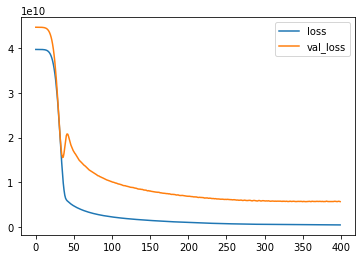

In [48]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

MAE: 26251.255299831082
MSE: 5732385819.709703
RMSE: 75712.52089126146
VarScore: 0.3086167623903652


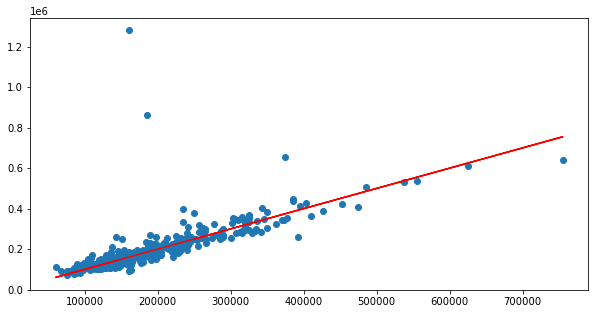

In [49]:
y_pred = model.predict(X_test)
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('VarScore:',metrics.explained_variance_score(y_test,y_pred))
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred)
# Perfect predictions
plt.plot(y_test,y_test,'r')


C:\Users\colli\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

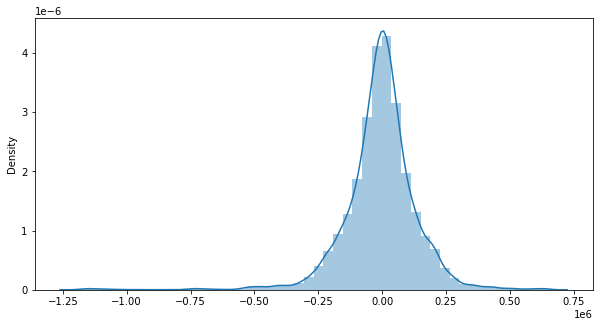

In [50]:
# visualizing residuals
fig = plt.figure(figsize=(10,5))
residuals = (y_test- y_pred)
sns.distplot(residuals)